In [63]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
DRIVE_PATH = "/content/drive/MyDrive/MTechCSE_2020/Term_Paper/Sem_6_analysis/Detectron2"

In [4]:
# Root directory of the project
CURR_DIR = "/content/Detectron2"

In [5]:
!rm -rf CURR_DIR

In [6]:
#ignore all Warnings
import warnings; warnings.simplefilter('ignore')

In [7]:
import shutil
import os
import sys
def loadToMemory():
  if not os.path.exists(CURR_DIR):
    shutil.copytree(DRIVE_PATH, CURR_DIR)
  else:
      print(f"Detectron2 Folder exsist")

In [8]:
loadToMemory()

In [ ]:
from google.colab import drive
drive.flush_and_unmount()

In [1]:
import os
os.chdir('./Detectron2')
os.getcwd()

'/content/Detectron2'

In [68]:
!ls

 BrainTumor_Detectron2.ipynb				   output
 coco_eval						   test
'Copy of Detectron2_custom_coco_data_segmentation.ipynb'   train
 detectron2_repo					   valid


In [ ]:
!pip install -U torch torchvision
!pip install git+https://github.com/facebookresearch/fvcore.git
import torch, torchvision
torch.__version__

In [12]:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

Cloning into 'detectron2_repo'...
remote: Enumerating objects: 15149, done.
remote: Counting objects: 100% (170/170), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 15149 (delta 89), reused 106 (delta 51), pack-reused 14979
Receiving objects: 100% (15149/15149), 6.20 MiB | 7.62 MiB/s, done.
Resolving deltas: 100% (10951/10951), done.
Obtaining file:///content/Detectron2/detectron2_repo
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 62.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 14.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-

In [3]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog, build_detection_test_loader
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
import os

In [ ]:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("brain_tumor1", {}, "./train/_annotations.coco.json", "./train")

In [4]:
def register_data():
    register_coco_instances("brain_tumor_train", {}, "./train/_annotations.coco.json", "./train")
    register_coco_instances("brain_tumor_valid", {}, "./valid/_annotations.coco.json", "./valid")
    register_coco_instances("brain_tumor_test", {}, "./test/_annotations.coco.json", "./test")

In [5]:
register_data()

In [6]:
brain_tumor_train_metadata = MetadataCatalog.get("brain_tumor_train")
dataset_dicts_train = DatasetCatalog.get("brain_tumor_train")

WARNING [07/20 20:08:21 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/20 20:08:21 d2.data.datasets.coco]: Loaded 500 images in COCO format from ./train/_annotations.coco.json


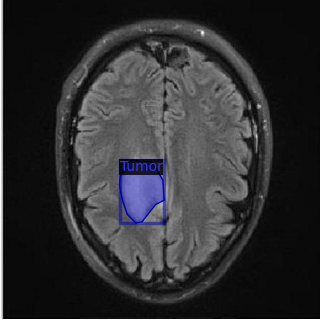

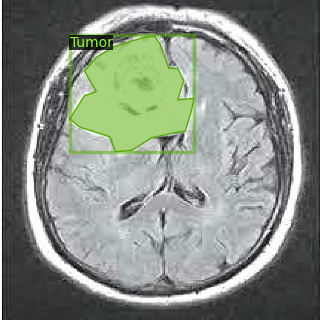

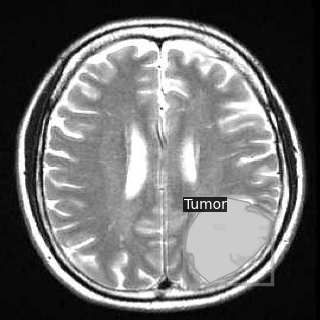

In [7]:
import random

for d in random.sample(dataset_dicts_train, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=brain_tumor_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [32]:
def config():
    cfg = get_cfg()
    # https://github.com/facebookresearch/detectron2/blob/main/configs/COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml
    cfg.merge_from_file("./detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml") #mask_rcnn_R_50_FPN_3x.yaml
    cfg.DATASETS.TRAIN = ("brain_tumor_train",)
    cfg.DATASETS.TEST = ("brain_tumor_valid",)
    cfg.DATALOADER.NUM_WORKERS = 2
    # https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x/138205316/model_final_a3ec72.pkl
    # cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo
    cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x/138205316/model_final_a3ec72.pkl"  # initialize from model zoo
    # cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/mask_rcnn_R_101_FPN_3x.yaml")  # Let training initialize from model zoo
    cfg.SOLVER.IMS_PER_BATCH = 2
    cfg.SOLVER.BASE_LR = 0.001 # pick a good LR
    cfg.SOLVER.MAX_ITER = 100    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
    cfg.SOLVER.STEPS = []        # do not decay learning rate
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64  # faster, and good enough for this toy dataset (default: 512)
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
    cfg.TEST.EVAL_PERIOD = 500
    return cfg

In [33]:
def train():
    cfg = config()
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    # trainer = DefaultTrainer(cfg)
    trainer = CocoTrainer(cfg)
    trainer.resume_or_load(resume=False)
    trainer.train()
    return trainer

In [34]:
trainer = train()

[07/20 20:30:49 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[07/20 20:30:50 d2.engine.train_loop]: Starting training from iteration 0
[07/20 20:30:59 d2.utils.events]:  eta: 0:00:37  iter: 19  total_loss: 2.293  loss_cls: 0.8754  loss_box_reg: 0.7799  loss_mask: 0.6756  loss_rpn_cls: 0.02529  loss_rpn_loc: 0.005687    time: 0.4670  last_time: 0.5539  data_time: 0.0190  last_data_time: 0.0240   lr: 0.00019081  max_mem: 5086M
[07/20 20:31:09 d2.utils.events]:  eta: 0:00:28  iter: 39  total_loss: 1.705  loss_cls: 0.3819  loss_box_reg: 0.7763  loss_mask: 0.5105  loss_rpn_cls: 0.02104  loss_rpn_loc: 0.004803    time: 0.4729  last_time: 0.4282  data_time: 0.0091  last_data_time: 0.0118   lr: 0.00039061  max_mem: 5086M
[07/20 20:31:19 d2.utils.events]:  eta: 0:00:19  iter: 59  total_loss: 1.163  loss_cls: 0.1898  loss_box_reg: 0.6807  loss_mask: 0.2274  loss_rpn_cls: 0.00353  loss_rpn_loc: 0.003304    time: 0.4811  last_time: 0.3909  data_time: 0.0142  last_data_time: 0.0053   lr: 0.00059041  max_mem: 5088M
[07/20 20:31:29 d2.utils.events]:  eta: 0:00

In [35]:
#We are importing our own Trainer Module here to use the COCO validation evaluation during training. Otherwise no validation eval occurs.

from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [57]:
def test():
    cfg = config()
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
    cfg.DATASETS.TEST = ("brain_tumor_test", )
    predictor = DefaultPredictor(cfg)
    evaluator = COCOEvaluator("brain_tumor_test", cfg, False, output_dir="./output/")
    val_loader = build_detection_test_loader(cfg, "brain_tumor_test")
    inference_on_dataset(trainer.model, val_loader, evaluator)


    return predictor

In [58]:
predictor = test()

[07/20 20:56:00 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...
WARNING [07/20 20:56:00 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [07/20 20:56:00 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/20 20:56:00 d2.data.datasets.coco]: Loaded 100 images in COCO format from ./test/_annotations.coco.json
[07/20 20:56:00 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[07/20 20:56:00 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[07/20 20:56:00 d2.data.common]: Serializing 100 elements to byte tensors and concatenating them all ...
[07/20 20:56:00 d2.data.common]: Serialized dataset takes 0.03 

WARNING [07/20 20:56:24 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/20 20:56:24 d2.data.datasets.coco]: Loaded 100 images in COCO format from ./test/_annotations.coco.json


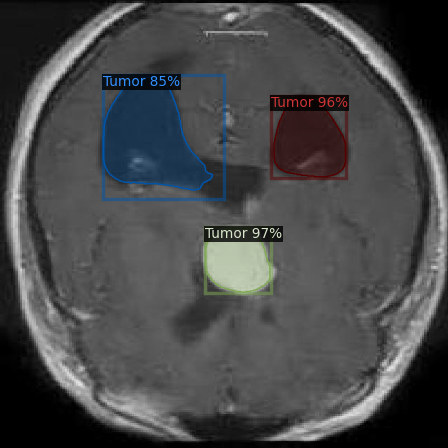

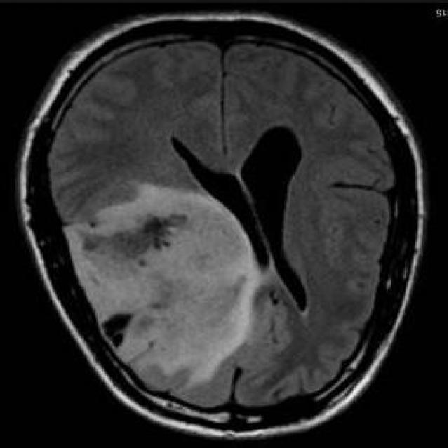

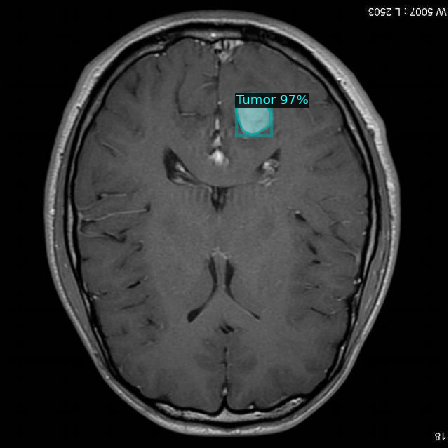

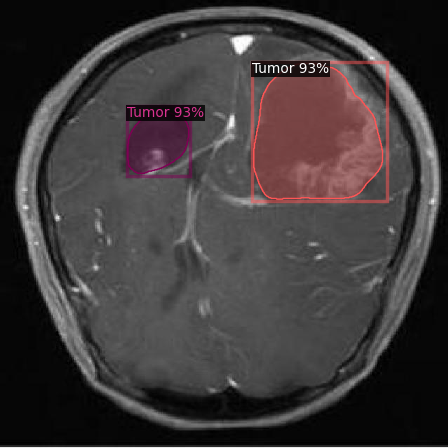

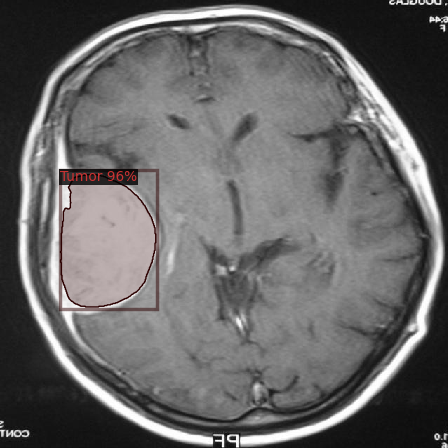

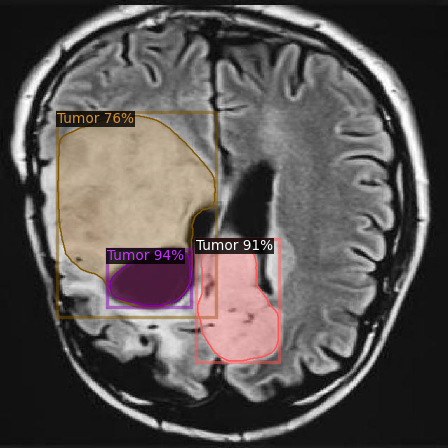

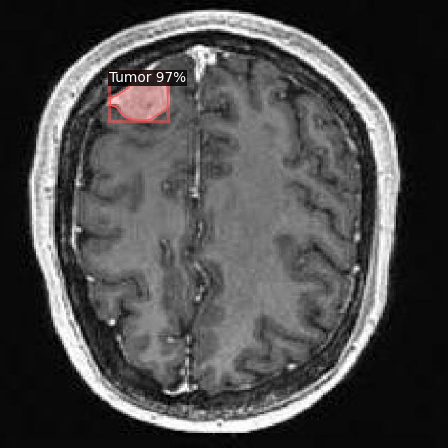

In [59]:
test_set = DatasetCatalog.get("brain_tumor_test")
for d in random.sample(test_set,7):
    im = cv2.imread(d["file_name"])
    outputs = predictor(
        im)
    v = Visualizer(im[:, :, ::-1],
                    metadata=MetadataCatalog.get("brain_tumor_test"),
                    scale=0.7,
                    instance_mode=ColorMode.IMAGE_BW
                    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    img = cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_RGBA2RGB)
    cv2_imshow(img[:, :, ::-1])

In [85]:
brain_tumor_train_metadata


namespace(name='brain_tumor_train',
          json_file='./train/_annotations.coco.json',
          image_root='./train',
          evaluator_type='coco',
          thing_classes=['Tumor', 'Tumor'],
          thing_dataset_id_to_contiguous_id={0: 0, 1: 1})

In [61]:
import time
times = []
for i in range(20):
    start_time = time.time()
    outputs = predictor(im)
    delta = time.time() - start_time
    times.append(delta)
mean_delta = np.array(times).mean()
fps = 1 / mean_delta
print("Average(sec):{:.2f},fps:{:.2f}".format(mean_delta, fps))

Average(sec):0.13,fps:7.98


In [54]:
def visualize_data():
    dataset_dicts = DatasetCatalog.get("brain_tumor_train")
    for d in random.sample(dataset_dicts, 3):
        print(d["annotations"])
        img = cv2.imread(d["file_name"])
        visualizer = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get("brain_tumor_train"), scale=0.5)
        out = visualizer.draw_dataset_dict(d)
        cv2_imshow(out.get_image()[:, :, ::-1])

WARNING [07/20 20:50:26 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/20 20:50:26 d2.data.datasets.coco]: Loaded 500 images in COCO format from ./train/_annotations.coco.json
[{'iscrowd': 0, 'bbox': [89, 81, 192.235, 211.321], 'category_id': 1, 'segmentation': [[194.579, 287.799, 227.399, 291.824, 257.875, 287.799, 271.941, 267.673, 281.319, 237.484, 278.974, 195.22, 271.941, 156.981, 264.908, 124.78, 248.498, 104.654, 218.022, 88.553, 185.201, 80.503, 157.07, 90.566, 131.282, 126.792, 119.56, 150.943, 100.806, 175.094, 100.806, 195.22, 89.084, 223.396, 91.429, 239.497, 114.872, 261.635, 152.381, 287.799, 194.579, 287.799]], 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [373, 153, 93.773, 102.641], 'category_id': 1, 'segmentation': [[461.832, 211.321, 457.143, 193.208, 438.388, 169.057, 412.601, 152.956, 386.813, 165.031, 375.092, 179.119, 372.747, 207.296, 393.846, 235.472, 414.945, 249.56, 443.077, 

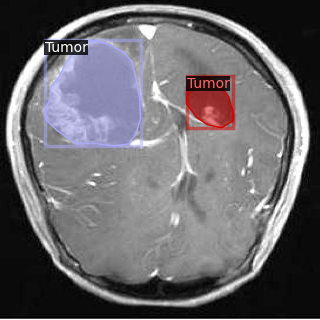

[{'iscrowd': 0, 'bbox': [44, 253, 276.463, 303.157], 'category_id': 1, 'segmentation': [[211.156, 555.789, 265.578, 544, 289.524, 532.211, 274.286, 510.316, 280.816, 490.105, 296.054, 490.105, 313.469, 481.684, 313.469, 473.263, 320, 459.789, 313.469, 429.474, 306.939, 416, 300.408, 399.158, 311.293, 382.316, 298.231, 372.211, 293.878, 346.947, 254.694, 294.737, 235.102, 274.526, 211.156, 261.053, 187.211, 252.632, 154.558, 254.316, 139.822, 256.453, 97.959, 267.789, 74.014, 276.211, 43.537, 282.947, 47.891, 311.579, 45.714, 348.632, 50.068, 378.947, 56.599, 410.947, 69.66, 446.316, 84.898, 468.211, 95.782, 490.105, 115.374, 510.316, 145.85, 528.842, 182.857, 549.053, 211.156, 555.789]], 'bbox_mode': <BoxMode.XYWH_ABS: 1>}]


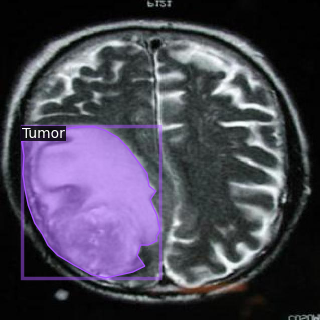

[{'iscrowd': 0, 'bbox': [384, 240, 218.824, 162.253], 'category_id': 1, 'segmentation': [[576.471, 362.366, 602.353, 322.704, 583.529, 299.268, 555.294, 299.268, 512.941, 259.606, 440, 239.775, 383.529, 259.606, 400, 299.268, 392.941, 344.338, 397.647, 380.394, 451.765, 391.211, 503.529, 393.014, 538.824, 402.028, 562.353, 367.775, 576.471, 362.366]], 'bbox_mode': <BoxMode.XYWH_ABS: 1>}]


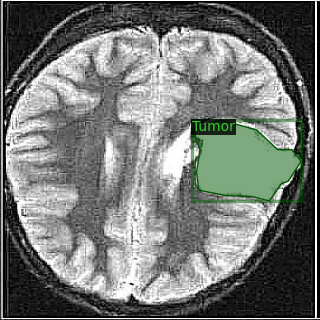

In [55]:
visualize_data()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from detectron2.structures import BoxMode

dataset_dicts = DatasetCatalog.get("brain_tumor_train")
class_names = MetadataCatalog.get("brain_tumor_train").thing_classes

df = []
for d in dataset_dicts:
    for ann in d["annotations"]:
        record = {}
        record["filename"] = d["file_name"]
        record["width"] = d["width"]
        record["height"] = d["height"]
        record["class"] = class_names[ann["category_id"]]
        record["xmin"] = ann["bbox"][0]
        record["ymin"] = ann["bbox"][1]
        record["xmax"] = ann["bbox"][0] + ann["bbox"][2]
        record["ymax"] = ann["bbox"][1] + ann["bbox"][3]
        df.append(record)
df = pd.DataFrame(df)

sns.countplot(data=df, y="class")
plt.show()

df["bbox_width"] = df["xmax"] - df["xmin"]
df["bbox_height"] = df["ymax"] - df["ymin"]
sns.histplot(data=df, x="bbox_width", kde=True)
plt.show()
sns.histplot(data=df, x="bbox_height", kde=True)
plt.show()

def get_custom_dataset_dicts():
    dataset_dicts = []
    for idx, row in df.iterrows():
        record = {}
        record["file_name"] = row["filename"]
        record["image_id"] = idx
        record["height"] = row["height"]
        record["width"] = row["width"]
        objs = [{            "bbox": [row["xmin"], row["ymin"], row["xmax"], row["ymax"]],
            "bbox_mode": BoxMode.XYXY_ABS,
            "category_id": class_names.index(row["class"])
        }]
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

DatasetCatalog.register("brain_tumor_val", get_custom_dataset_dicts)
MetadataCatalog.get("brain_tumor_val").set(thing_classes=class_names)

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir "./output"

In [1]:
import ast
import json

import matplotlib.pyplot as plt
import numpy as np


def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


metrics_file = './metrics.json'

with open(metrics_file, 'r') as f:
    metrics = [ast.literal_eval(l[:-1]) for l in f.readlines()]
    f.close()

train_loss = [float(v['loss_box_reg']) for v in metrics if 'loss_box_reg' in v.keys()]
val_loss = [float(v['val_loss_box_reg']) for v in metrics if 'val_loss_box_reg' in v.keys()]

N = 40

train_loss_avg = moving_average(train_loss, n=N)
val_loss_avg = moving_average(val_loss, n=N)

plt.plot(range(20 * N - 1, 20 * len(train_loss), 20), train_loss_avg, label='train loss')
plt.plot(range(20 * N - 1, 20 * len(train_loss), 20), val_loss_avg, label='val loss')
plt.legend()
plt.grid()
plt.show()

FileNotFoundError: ignored